# Task One: Subspace Alignment

## Import Libraries and Set Up Environment

In [1]:
import numpy as np
import scipy.io
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

## Load and Preview the Data - CaffeNet4096
Load the webcam.mat and dslr.mat files provided in the Office/Caltech dataset.

Webcam -> source

DSLR -> target

In [2]:
# Load Webcam (source domain) data
webcam_data = scipy.io.loadmat('CaffeNet4096/webcam.mat')
X_source = webcam_data['fts']  # Feature matrix
y_source = webcam_data['labels'].ravel()  # Label vector

# Load DSLR (target domain) data
dslr_data = scipy.io.loadmat('CaffeNet4096/dslr.mat')
X_target = dslr_data['fts']
y_target = dslr_data['labels'].ravel()

print(f"Source data shape (features): {X_source.shape}, labels: {y_source.shape}")
print(f"Target data shape (features): {X_target.shape}, labels: {y_target.shape}")

Source data shape (features): (295, 4096), labels: (295,)
Target data shape (features): (157, 4096), labels: (157,)


In [3]:
print(f"Number of classes in the source dataset: {len(np.unique(y_source))}")
print(f"Number of classes in the target dataset: {len(np.unique(y_target))}")

Number of classes in the source dataset: 10
Number of classes in the target dataset: 10


## Data Preprocessing
Apply z-score normalization to standardize both source and target data.


In [4]:
# Pre-process the data matrix using z-score normalization
scaler = StandardScaler()

X_source = scaler.fit_transform(X_source)
X_target = scaler.transform(X_target)

## Principal Component Analysis (PCA)

Compute the principal components for both source and target data to reduce them to d dimensions.

In [5]:
# Define d, the target dimension
d = 10
pca_source = PCA(n_components=d)
pca_target = PCA(n_components=d)

# Transform the data
S_hat = pca_source.fit_transform(X_source)
T_hat = pca_target.fit_transform(X_target)
print(S_hat.shape)
print(T_hat.shape)

(295, 10)
(157, 10)


## Compute the Alignment Matrix

Calculate the optimal alignment matrix $M = X_s^TX_t$.
Compute $M$ using the principal components, which represent the direction of maximum variance in the data for each domain.

In [6]:
# Calculate alignment matrix M
Xs = pca_source.components_.T
Xt = pca_target.components_.T
print(Xs.shape)
print(Xt.shape)
M = np.dot(Xs.T, Xt)
print(M.shape)

(4096, 10)
(4096, 10)
(10, 10)


## Project Source Data Using Alignment Matrix

Apply the alignment matrix to the projected source data to obtain $S_p$ (the target aligned source domain)

$S_p = \hat{S}M$

In [7]:
S_p = np.dot(S_hat, M)

## Nearest Neighbor Classification

Implement 1-NN classification to predict labels of the target domain based on transformed source data.

In [8]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(S_p, y_source)
predictions = knn.predict(T_hat)

## Evaluation

Calculate and display the classification accuracy on the target data.

In [9]:
accuracy = accuracy_score(y_target, predictions)
print(f"Accuracy of Subspace Alignment: {accuracy * 100:.2f}%")

Accuracy of Subspace Alignment: 92.99%


## Subspace Alignment method as a function
Implement the subspace alignment method as a function in Python taking as input the initial
data matrices S and T as well as the parameter d and outputting the accuracy of the final classifier

In [10]:
def subspace_alignment(X_source, y_source, X_target, y_target, d):

  # PCA
  pca_source = PCA(n_components=d)
  pca_target = PCA(n_components=d)
  S_hat = pca_source.fit_transform(X_source)
  T_hat = pca_target.fit_transform(X_target)

  # Calculate alignment matrix M
  Xs = pca_source.components_.T
  Xt = pca_target.components_.T
  M = np.dot(Xs.T, Xt)

  # Project the source data using the alignment matrix
  S_p = np.dot(S_hat, M)

  # Implement 1-NN to predict labels of the target domain based on transformed source data
  knn = KNeighborsClassifier(n_neighbors=1)
  knn.fit(S_p, y_source)
  predictions = knn.predict(T_hat)

  # Evaluate the model
  accuracy = accuracy_score(y_target, predictions)

  return accuracy

## Fine-tuning d

In [12]:
# n_components must be between 0 and min(n_samples, n_features)=157
d_values = [1, 10, 20, 30, 40, 50, 100, 157]
k = 5
best_d = None
best_accuracy = 0
results = []

# Cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)
for d in d_values:
    fold_accuracies = []
    for train_index, test_index in kf.split(X_source):
        # Split source data into train and validation sets for current fold
        X_train, X_val = X_source[train_index], X_source[test_index]
        y_train, y_val = y_source[train_index], y_source[test_index]

        # Run subspace alignment and get accuracy for this fold
        accuracy = subspace_alignment(X_train, y_train, X_target, y_target, d=d)
        fold_accuracies.append(accuracy)

    # Calculate mean accuracy across folds for current d
    mean_accuracy = np.mean(fold_accuracies)
    results.append((d, mean_accuracy))

    # Update the best d
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_d = d

print("Cross-validation results:")
for d, acc in results:
    print(f"d = {d}, Mean Accuracy = {acc * 100:.2f}%")
print(f"\nBest value of d: {best_d} with accuracy: {best_accuracy * 100:.2f}%")

Cross-validation results:
d = 1, Mean Accuracy = 16.94%
d = 10, Mean Accuracy = 93.25%
d = 20, Mean Accuracy = 99.36%
d = 30, Mean Accuracy = 100.00%
d = 40, Mean Accuracy = 99.87%
d = 50, Mean Accuracy = 100.00%
d = 100, Mean Accuracy = 99.87%
d = 157, Mean Accuracy = 99.49%

Best value of d: 30 with accuracy: 100.00%


In [13]:
# Accuracy of the best d over the whole dataset
acc = subspace_alignment(X_source, y_source, X_target, y_target, 30)
print(f"Best accuracy: {acc * 100:.2f}%")

Best accuracy: 100.00%


## Comparison with Baseline

Compare performance with a 1-NN classifier trained on the raw source data (no projection).

In [14]:
knn_baseline = KNeighborsClassifier(n_neighbors=1)
knn_baseline.fit(X_source, y_source)
predictions_baseline = knn_baseline.predict(X_target)
baseline_accuracy = accuracy_score(y_target, predictions_baseline)
print(f"Baseline Accuracy (without projection): {baseline_accuracy * 100:.2f}%")

Baseline Accuracy (without projection): 96.18%


## Visualization of the distributions of source and target data before and after the alignment

In [15]:
def visualize_data(X_source, X_target, S_p, y_source, y_target):
  tsne = TSNE(n_components=2, random_state=42)

  X_s_2d = tsne.fit_transform(X_source)
  X_t_2d = tsne.fit_transform(X_target)

  S_a_2d = tsne.fit_transform(S_p)

  plt.figure(figsize=(14, 6))
  plt.subplot(1, 2, 1)
  plt.scatter(X_s_2d[:, 0], X_s_2d[:, 1], c=y_source, marker='o', label='Source Domain', alpha=0.5, cmap='viridis')
  plt.scatter(X_t_2d[:, 0], X_t_2d[:, 1], c=y_target, marker='x', label='Target Domain', alpha=0.5, cmap='plasma')
  plt.title("Original Source and Target Data")
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.scatter(S_a_2d[:, 0], S_a_2d[:, 1], c=y_source, marker='^', label='Target aligned source', alpha=0.5, cmap='viridis')
  plt.scatter(X_t_2d[:, 0], X_t_2d[:, 1], c=y_target, marker='x', label='Target Domain', alpha=0.5, cmap='plasma')
  plt.title("Transported Source and Target Data")
  plt.legend()

  plt.show()

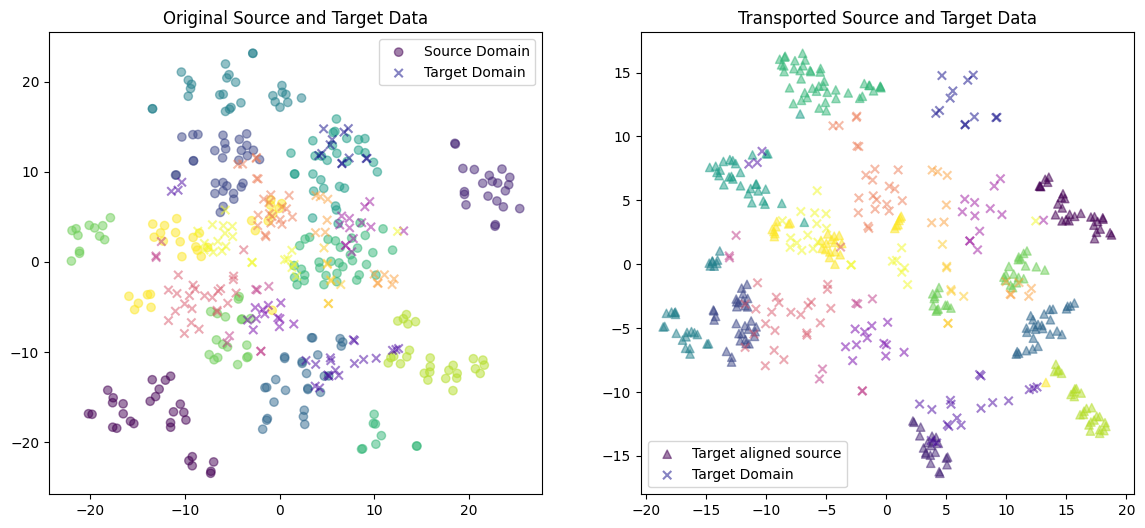

In [16]:
# PCA
pca_source = PCA(n_components=30)
pca_target = PCA(n_components=30)
S_hat = pca_source.fit_transform(X_source)
T_hat = pca_target.fit_transform(X_target)

# Calculate alignment matrix M
Xs = pca_source.components_.T
Xt = pca_target.components_.T
M = np.dot(Xs.T, Xt)

# Project the source data using the alignment matrix
S_p = np.dot(S_hat, M)

visualize_data(X_source, X_target, S_p, y_source, y_target)

## Switching source and target domains - CaffeNet4096

DSLR -> source

Webcam -> target

In [18]:
# Load Webcam (target domain) data
webcam_data = scipy.io.loadmat('CaffeNet4096/webcam.mat')
X_target = webcam_data['fts']  # Feature matrix
y_target = webcam_data['labels'].ravel()

# Load DSLR (source domain) data
dslr_data = scipy.io.loadmat('CaffeNet4096/dslr.mat')
X_source = dslr_data['fts']
y_source = dslr_data['labels'].ravel()

# Pre-process the data matrix using z-score normalization
scaler = StandardScaler()
X_source = scaler.fit_transform(X_source)
X_target = scaler.transform(X_target)

In [19]:
# n_components must be between 0 and min(n_samples, n_features)=125 (=number of folds * size of each fold = 4*31.4)
d_values = [1, 10, 20, 30, 40, 50, 100, 110, 125]
k = 5
best_d = None
best_accuracy = 0
results = []

# Cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)
for d in d_values:
    fold_accuracies = []
    for train_index, test_index in kf.split(X_source):
        # Split source data into train and validation sets for current fold
        X_train, X_val = X_source[train_index], X_source[test_index]
        y_train, y_val = y_source[train_index], y_source[test_index]

        # Run subspace alignment and get accuracy for this fold
        accuracy = subspace_alignment(X_train, y_train, X_target, y_target, d=d)
        fold_accuracies.append(accuracy)

    # Calculate mean accuracy across folds for current d
    mean_accuracy = np.mean(fold_accuracies)
    results.append((d, mean_accuracy))

    # Update the best d
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_d = d

print("Cross-validation results:")
for d, acc in results:
    print(f"d = {d}, Mean Accuracy = {acc * 100:.2f}%")
print(f"\nBest value of d: {best_d} with accuracy: {best_accuracy * 100:.2f}%")

Cross-validation results:
d = 1, Mean Accuracy = 10.37%
d = 10, Mean Accuracy = 15.80%
d = 20, Mean Accuracy = 29.29%
d = 30, Mean Accuracy = 56.61%
d = 40, Mean Accuracy = 68.27%
d = 50, Mean Accuracy = 72.20%
d = 100, Mean Accuracy = 72.07%
d = 110, Mean Accuracy = 71.53%
d = 125, Mean Accuracy = 72.00%

Best value of d: 50 with accuracy: 72.20%


In [21]:
# Accuracy of the best d over the whole dataset
acc = subspace_alignment(X_source, y_source, X_target, y_target, 50)
print(f"Best accuracy: {acc * 100:.2f}%")

Best accuracy: 73.22%


In [22]:
# Comparison with the baseline
knn_baseline = KNeighborsClassifier(n_neighbors=1)
knn_baseline.fit(X_source, y_source)
predictions_baseline = knn_baseline.predict(X_target)
baseline_accuracy = accuracy_score(y_target, predictions_baseline)
print(f"Baseline Accuracy (without projection): {baseline_accuracy * 100:.2f}%")

Baseline Accuracy (without projection): 63.39%


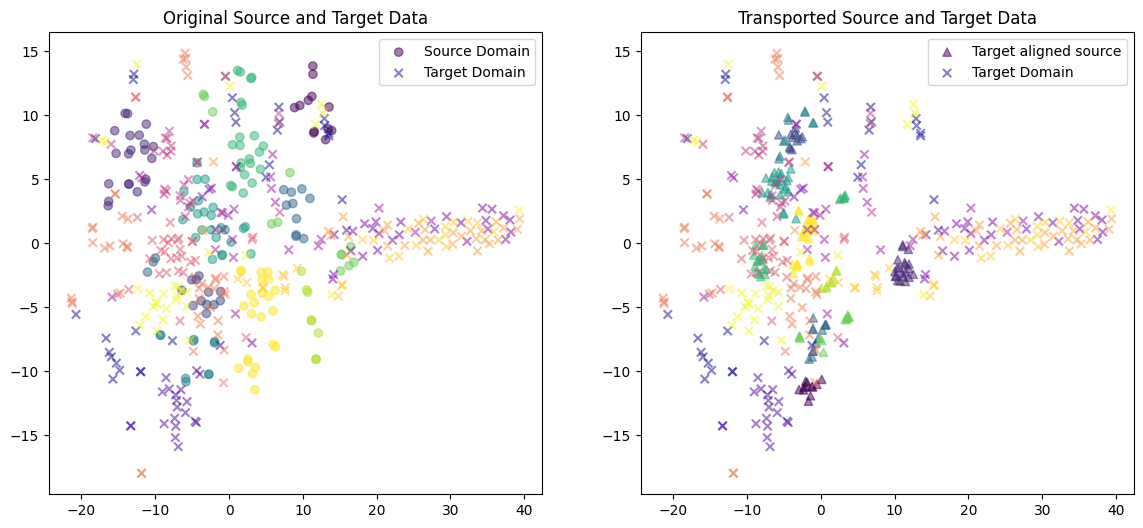

In [23]:
# Visualization of the distributions of source and target data before and after the alignment

# PCA
pca_source = PCA(n_components=50)
pca_target = PCA(n_components=50)
S_hat = pca_source.fit_transform(X_source)
T_hat = pca_target.fit_transform(X_target)

# Calculate alignment matrix M
Xs = pca_source.components_.T
Xt = pca_target.components_.T
M = np.dot(Xs.T, Xt)

# Project the source data using the alignment matrix
S_p = np.dot(S_hat, M)

visualize_data(X_source, X_target, S_p, y_source, y_target)

## Loading the data - surf

Webcam -> source

DSLR -> target

In [30]:
# Load Webcam (source domain) data
webcam_data = scipy.io.loadmat('surf/webcam.mat')
X_source = webcam_data['fts']  # Feature matrix
y_source = webcam_data['labels'].ravel()  # Label vector

# Load DSLR (target domain) data
dslr_data = scipy.io.loadmat('surf/dslr.mat')
X_target = dslr_data['fts']
y_target = dslr_data['labels'].ravel()

# Pre-process the data matrix using z-score normalization
scaler = StandardScaler()
X_source = scaler.fit_transform(X_source)
X_target = scaler.transform(X_target)

In [31]:
# n_components must be between 0 and min(n_samples, n_features)=157
d_values = [1, 10, 20, 30, 40, 50, 100, 157]
k = 5
best_d = None
best_accuracy = 0
results = []

# Cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)
for d in d_values:
    fold_accuracies = []
    for train_index, test_index in kf.split(X_source):
        # Split source data into train and validation sets for current fold
        X_train, X_val = X_source[train_index], X_source[test_index]
        y_train, y_val = y_source[train_index], y_source[test_index]

        # Run subspace alignment and get accuracy for this fold
        accuracy = subspace_alignment(X_train, y_train, X_target, y_target, d=d)
        fold_accuracies.append(accuracy)

    # Calculate mean accuracy across folds for current d
    mean_accuracy = np.mean(fold_accuracies)
    results.append((d, mean_accuracy))

    # Update the best d
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_d = d

print("Cross-validation results:")
for d, acc in results:
    print(f"d = {d}, Mean Accuracy = {acc * 100:.2f}%")
print(f"\nBest value of d: {best_d} with accuracy: {best_accuracy * 100:.2f}%")

Cross-validation results:
d = 1, Mean Accuracy = 25.48%
d = 10, Mean Accuracy = 61.02%
d = 20, Mean Accuracy = 73.25%
d = 30, Mean Accuracy = 78.98%
d = 40, Mean Accuracy = 83.69%
d = 50, Mean Accuracy = 84.20%
d = 100, Mean Accuracy = 85.48%
d = 157, Mean Accuracy = 83.69%

Best value of d: 100 with accuracy: 85.48%


In [32]:
# Accuracy of the best d over the whole dataset
acc = subspace_alignment(X_source, y_source, X_target, y_target, 100)
print(f"Best accuracy: {acc * 100:.2f}%")

Best accuracy: 90.45%


In [33]:
# Comparison with the baseline
knn_baseline = KNeighborsClassifier(n_neighbors=1)
knn_baseline.fit(X_source, y_source)
predictions_baseline = knn_baseline.predict(X_target)
baseline_accuracy = accuracy_score(y_target, predictions_baseline)
print(f"Baseline Accuracy (without projection): {baseline_accuracy * 100:.2f}%")

Baseline Accuracy (without projection): 43.31%


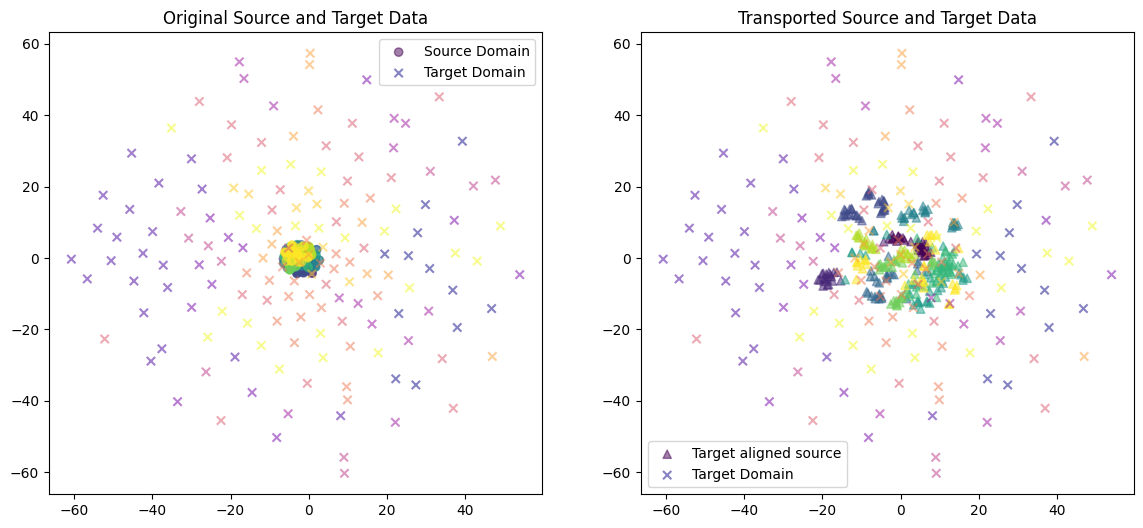

In [34]:
# Visualization of the distributions of source and target data before and after the alignment

# PCA
pca_source = PCA(n_components=50)
pca_target = PCA(n_components=50)
S_hat = pca_source.fit_transform(X_source)
T_hat = pca_target.fit_transform(X_target)

# Calculate alignment matrix M
Xs = pca_source.components_.T
Xt = pca_target.components_.T
M = np.dot(Xs.T, Xt)

# Project the source data using the alignment matrix
S_p = np.dot(S_hat, M)

visualize_data(X_source, X_target, S_p, y_source, y_target)

## Switching source and target domains - surf

DSLR -> source

Webcam -> target

In [35]:
# Load Webcam (target domain) data
webcam_data = scipy.io.loadmat('surf/webcam.mat')
X_target = webcam_data['fts']  # Feature matrix
y_target = webcam_data['labels'].ravel()

# Load DSLR (source domain) data
dslr_data = scipy.io.loadmat('surf/dslr.mat')
X_source = dslr_data['fts']
y_source = dslr_data['labels'].ravel()

# Pre-process the data matrix using z-score normalization
scaler = StandardScaler()
X_source = scaler.fit_transform(X_source)
X_target = scaler.transform(X_target)

In [36]:
# n_components must be between 0 and min(n_samples, n_features)=125 (=number of folds * size of each fold = 4*31.4)
d_values = [1, 10, 20, 30, 40, 50, 100, 110, 125]
k = 5
best_d = None
best_accuracy = 0
results = []

# Cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)
for d in d_values:
    fold_accuracies = []
    for train_index, test_index in kf.split(X_source):
        # Split source data into train and validation sets for current fold
        X_train, X_val = X_source[train_index], X_source[test_index]
        y_train, y_val = y_source[train_index], y_source[test_index]

        # Run subspace alignment and get accuracy for this fold
        accuracy = subspace_alignment(X_train, y_train, X_target, y_target, d=d)
        fold_accuracies.append(accuracy)

    # Calculate mean accuracy across folds for current d
    mean_accuracy = np.mean(fold_accuracies)
    results.append((d, mean_accuracy))

    # Update the best d
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_d = d

print("Cross-validation results:")
for d, acc in results:
    print(f"d = {d}, Mean Accuracy = {acc * 100:.2f}%")
print(f"\nBest value of d: {best_d} with accuracy: {best_accuracy * 100:.2f}%")

Cross-validation results:
d = 1, Mean Accuracy = 16.54%
d = 10, Mean Accuracy = 58.31%
d = 20, Mean Accuracy = 65.49%
d = 30, Mean Accuracy = 71.12%
d = 40, Mean Accuracy = 77.15%
d = 50, Mean Accuracy = 77.63%
d = 100, Mean Accuracy = 73.08%
d = 110, Mean Accuracy = 72.54%
d = 125, Mean Accuracy = 71.46%

Best value of d: 50 with accuracy: 77.63%


In [37]:
# Accuracy of the best d over the whole dataset
acc = subspace_alignment(X_source, y_source, X_target, y_target, 50)
print(f"Best accuracy: {acc * 100:.2f}%")

Best accuracy: 83.39%


In [38]:
# Comparison with the baseline
knn_baseline = KNeighborsClassifier(n_neighbors=1)
knn_baseline.fit(X_source, y_source)
predictions_baseline = knn_baseline.predict(X_target)
baseline_accuracy = accuracy_score(y_target, predictions_baseline)
print(f"Baseline Accuracy (without projection): {baseline_accuracy * 100:.2f}%")

Baseline Accuracy (without projection): 33.22%


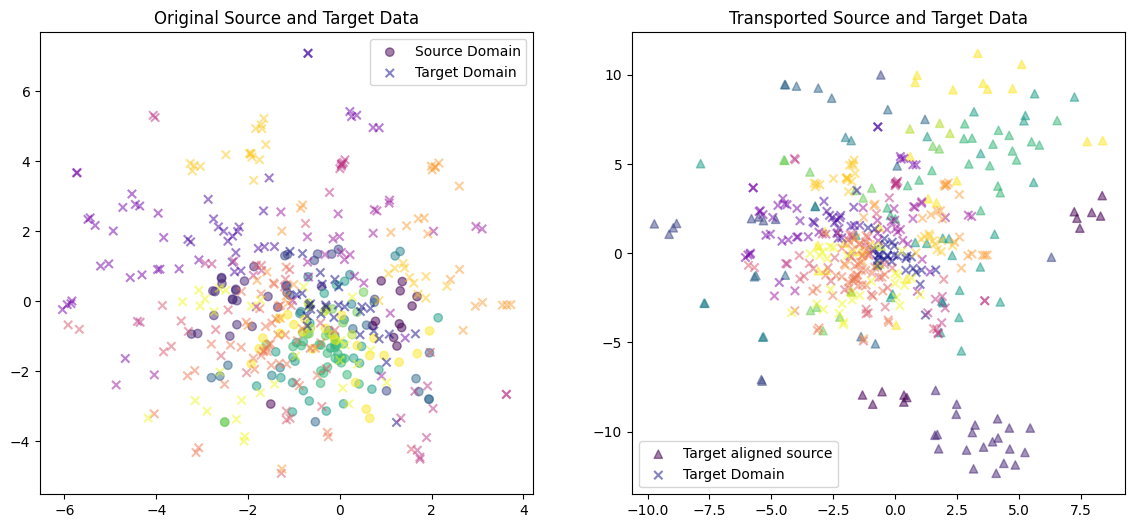

In [39]:
# Visualization of the distributions of source and target data before and after the alignment

# PCA
pca_source = PCA(n_components=50)
pca_target = PCA(n_components=50)
S_hat = pca_source.fit_transform(X_source)
T_hat = pca_target.fit_transform(X_target)

# Calculate alignment matrix M
Xs = pca_source.components_.T
Xt = pca_target.components_.T
M = np.dot(Xs.T, Xt)

# Project the source data using the alignment matrix
S_p = np.dot(S_hat, M)

visualize_data(X_source, X_target, S_p, y_source, y_target)

# Task Two: Entropic regularized optimal transport

## Import Libraries and Set Up Environment

In [ ]:
pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 32.7 MB/s eta 0:00:00


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat
from scipy.spatial.distance import cdist
import ot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

## Load and Pre-process data and Define Functions

In [43]:
def load_data_caffenet():
    data_webcam = loadmat('CaffeNet4096/webcam.mat')
    data_dslr = loadmat('CaffeNet4096/dslr.mat')
    X_s = data_webcam['fts']
    y_s = data_webcam['labels'].ravel()
    X_t = data_dslr['fts']
    y_t = data_dslr['labels'].ravel()
    return X_s, y_s, X_t, y_t

def load_data_surf():
    data_webcam = loadmat('surf/webcam.mat')
    data_dslr = loadmat('surf/dslr.mat')
    X_s = data_webcam['fts']
    y_s = data_webcam['labels'].ravel()
    X_t = data_dslr['fts']
    y_t = data_dslr['labels'].ravel()
    return X_s, y_s, X_t, y_t

def preprocess_data(X_s, X_t):
    scaler = StandardScaler()
    X_s = scaler.fit_transform(X_s)
    X_t = scaler.transform(X_t)
    return X_s, X_t

# Computing the Distance Matrix

def compute_cost_matrix(X_s, X_t):
    M = cdist(X_s, X_t, metric='euclidean')
    M /= (M.max() + 1e-9)
    return M

# Computing the Coupling Matrix

def calculate_coupling_matrix(M, reg_e):
    ns, nt = M.shape
    a = np.ones(ns) / ns
    b = np.ones(nt) / nt
    gamma = ot.sinkhorn(a, b, M, reg_e)
    return gamma

#Tansporting the Source

def transport_source_data(gamma, X_t):
    S_a = np.dot(gamma, X_t)
    return S_a

#Evakuating the Transportation

def evaluate_transportation(S_a, y_s, X_t, y_t):
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(S_a, y_s)

    y_pred = knn.predict(X_t)

    accuracy = accuracy_score(y_t, y_pred)
    return accuracy

def visualize_data(X_s, X_t, S_a, y_s, y_t):
    tsne = TSNE(n_components=2, random_state=42)

    X_s_2d = tsne.fit_transform(X_s)
    X_t_2d = tsne.fit_transform(X_t)

    S_a_2d = tsne.fit_transform(S_a)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(X_s_2d[:, 0], X_s_2d[:, 1], c=y_s, marker='o', label='Source Domain (X_s)', alpha=0.5, cmap='viridis')
    plt.scatter(X_t_2d[:, 0], X_t_2d[:, 1], c=y_t, marker='x', label='Target Domain (X_t)', alpha=0.5, cmap='plasma')
    plt.title("Original Source and Target Data")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.scatter(S_a_2d[:, 0], S_a_2d[:, 1], c=y_s, marker='^', label='Transported Source (S_a)', alpha=0.5, cmap='viridis')
    plt.scatter(X_t_2d[:, 0], X_t_2d[:, 1], c=y_t, marker='x', label='Target Domain (X_t)', alpha=0.5, cmap='plasma')
    plt.title("Transported Source and Target Data")
    plt.legend()

    plt.show()

## Grid Search

In [44]:
def tune_regularization(X_s, y_s, X_t, y_t, reg_e_values):
    best_accuracy = 0
    best_reg_e = None

    for reg_e in reg_e_values:
        print(f"Tuning with reg_e = {reg_e}...")

        M = compute_cost_matrix(X_s, X_t)

        gamma = calculate_coupling_matrix(M, reg_e)

        S_a = transport_source_data(gamma, X_t)

        accuracy = evaluate_transportation(S_a, y_s, X_t, y_t)

        print(f"Accuracy for reg_e={reg_e}: {accuracy:.5f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_reg_e = reg_e

    print(f"Best reg_e: {best_reg_e} with accuracy: {best_accuracy:.5f}")
    return best_reg_e

## Grid Search with Cross Validation

In [45]:
def evaluate_with_cross_validation(X_s, y_s, X_t, y_t, reg_e, n_splits=5):
    kf = KFold(n_splits=n_splits)
    accuracies = []

    for train_index, val_index in kf.split(X_s):
        X_train_s, X_val_s = X_s[train_index], X_s[val_index]
        y_train_s, y_val_s = y_s[train_index], y_s[val_index]

        kf_t = KFold(n_splits=n_splits)
        for train_index_t, val_index_t in kf_t.split(X_t):
            X_train_t, X_val_t = X_t[train_index_t], X_t[val_index_t]
            y_train_t, y_val_t = y_t[train_index_t], y_t[val_index_t]
            break

        M = compute_cost_matrix(X_train_s, X_train_t)
        gamma = calculate_coupling_matrix(M, reg_e)
        S_a = transport_source_data(gamma, X_train_t)

        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(S_a, y_train_s)
        y_pred = knn.predict(X_val_t)
        accuracy = accuracy_score(y_val_t, y_pred)
        accuracies.append(accuracy)

    return np.mean(accuracies)


def tune_regularization_cv(X_s, y_s, X_t, y_t, reg_e_values, n_splits=5):
    best_accuracy = 0
    best_reg_e = None

    for reg_e in reg_e_values:
        print(f"Tuning with reg_e = {reg_e}...")

        accuracy = evaluate_with_cross_validation(X_s, y_s, X_t, y_t, reg_e, n_splits)

        print(f"Accuracy for reg_e={reg_e}: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_reg_e = reg_e

    print()
    print(f"Best reg_e: {best_reg_e} with accuracy: {best_accuracy:.4f}")
    return best_reg_e

### With Caffenet

X_s shape: (295, 4096)
y_s shape: (295,)
X_t shape: (157, 4096)
y_t shape: (157,)
Gamma shape: (295, 157)
S_a shape: (295, 4096)
Accuracy before Entropic Regularized Optimal Transport: 0.96
Accuracy after Entropic Regularized Optimal Transport: 0.96


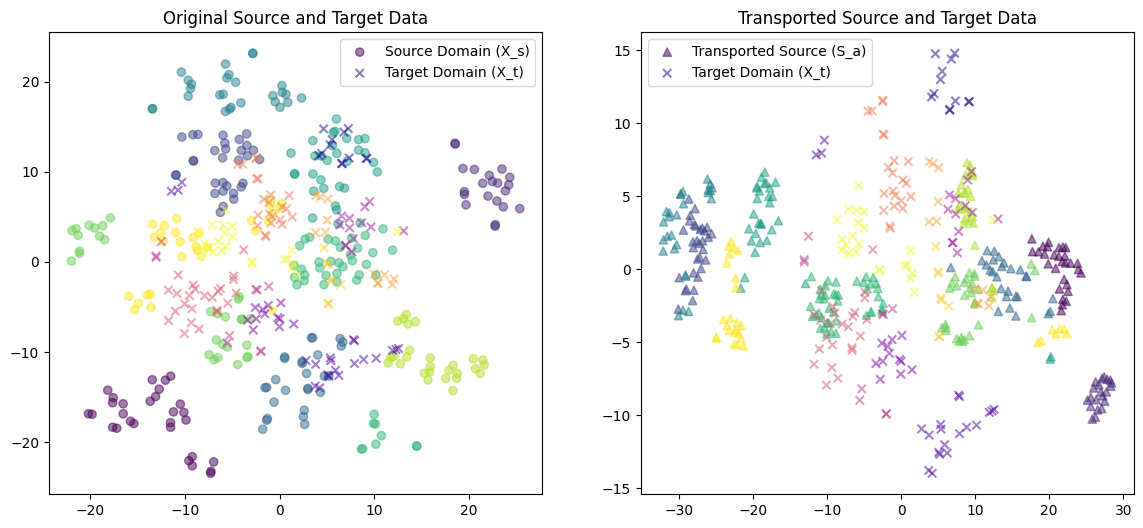

In [46]:
X_s, y_s, X_t, y_t = load_data_caffenet()

X_s, X_t = preprocess_data(X_s, X_t)

M = compute_cost_matrix(X_s, X_t)

gamma = calculate_coupling_matrix(M, reg_e = 5.0)

print("X_s shape:", X_s.shape)
print("y_s shape:", y_s.shape)
print("X_t shape:", X_t.shape)
print("y_t shape:", y_t.shape)
print("Gamma shape:", gamma.shape)


S_a = transport_source_data(gamma, X_t)
print("S_a shape:", S_a.shape)

accuracy1 = evaluate_transportation(X_s, y_s, X_t, y_t)
print(f"Accuracy before Entropic Regularized Optimal Transport: {accuracy1:.2f}")
accuracy = evaluate_transportation(S_a, y_s, X_t, y_t)
print(f"Accuracy after Entropic Regularized Optimal Transport: {accuracy:.2f}")

visualize_data(X_s, X_t, S_a, y_s, y_t)

In [47]:
reg_e_values = np.linspace(0.1, 5, 20)

best_reg_e = tune_regularization(X_s, y_s, X_t, y_t, reg_e_values)

print()
print(f"Evaluating final model with best reg_e = {best_reg_e}")

gamma = calculate_coupling_matrix(M, best_reg_e)
S_a = transport_source_data(gamma, X_t)
accuracy = evaluate_transportation(S_a, y_s, X_t, y_t)

print()
print(f"Final accuracy with best reg_e: {accuracy:.2f}")

Tuning with reg_e = 0.1...
Accuracy for reg_e=0.1: 0.95541
Tuning with reg_e = 0.35789473684210527...
Accuracy for reg_e=0.35789473684210527: 0.96178
Tuning with reg_e = 0.6157894736842106...
Accuracy for reg_e=0.6157894736842106: 0.96178
Tuning with reg_e = 0.8736842105263158...
Accuracy for reg_e=0.8736842105263158: 0.96178
Tuning with reg_e = 1.1315789473684212...
Accuracy for reg_e=1.1315789473684212: 0.96178
Tuning with reg_e = 1.3894736842105266...
Accuracy for reg_e=1.3894736842105266: 0.96178
Tuning with reg_e = 1.6473684210526318...
Accuracy for reg_e=1.6473684210526318: 0.96178
Tuning with reg_e = 1.905263157894737...
Accuracy for reg_e=1.905263157894737: 0.96178
Tuning with reg_e = 2.1631578947368424...
Accuracy for reg_e=2.1631578947368424: 0.96178
Tuning with reg_e = 2.421052631578948...
Accuracy for reg_e=2.421052631578948: 0.96178
Tuning with reg_e = 2.678947368421053...
Accuracy for reg_e=2.678947368421053: 0.96178
Tuning with reg_e = 2.936842105263158...
Accuracy for r

In [48]:
reg_e_values = np.linspace(0.01, 1, 20) #(0.01, 10, 30)
best_reg_e = tune_regularization_cv(X_s, y_s, X_t, y_t, reg_e_values)

gamma = calculate_coupling_matrix(M, best_reg_e)
S_a = transport_source_data(gamma, X_t)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(S_a, y_s)
y_pred = knn.predict(X_t)
final_accuracy = accuracy_score(y_t, y_pred)

print()
print(f"Final accuracy with best reg_e ({best_reg_e}): {final_accuracy:.4f}")

Tuning with reg_e = 0.01...
Accuracy for reg_e=0.01: 0.5312
Tuning with reg_e = 0.06210526315789474...
Accuracy for reg_e=0.06210526315789474: 0.5062
Tuning with reg_e = 0.11421052631578947...
Accuracy for reg_e=0.11421052631578947: 0.5125
Tuning with reg_e = 0.16631578947368422...
Accuracy for reg_e=0.16631578947368422: 0.5188
Tuning with reg_e = 0.21842105263157896...
Accuracy for reg_e=0.21842105263157896: 0.5188
Tuning with reg_e = 0.2705263157894737...
Accuracy for reg_e=0.2705263157894737: 0.5375
Tuning with reg_e = 0.32263157894736844...
Accuracy for reg_e=0.32263157894736844: 0.5375
Tuning with reg_e = 0.37473684210526315...
Accuracy for reg_e=0.37473684210526315: 0.5375
Tuning with reg_e = 0.4268421052631579...
Accuracy for reg_e=0.4268421052631579: 0.5375
Tuning with reg_e = 0.4789473684210527...
Accuracy for reg_e=0.4789473684210527: 0.5375
Tuning with reg_e = 0.5310526315789474...
Accuracy for reg_e=0.5310526315789474: 0.5375
Tuning with reg_e = 0.5831578947368421...
Accura

### With SURF

X_s shape: (295, 800)
y_s shape: (295,)
X_t shape: (157, 800)
y_t shape: (157,)
Gamma shape: (295, 157)
S_a shape: (295, 800)
Accuracy before Entropic Regularized Optimal Transport: 0.43
Accuracy after Entropic Regularized Optimal Transport: 0.87


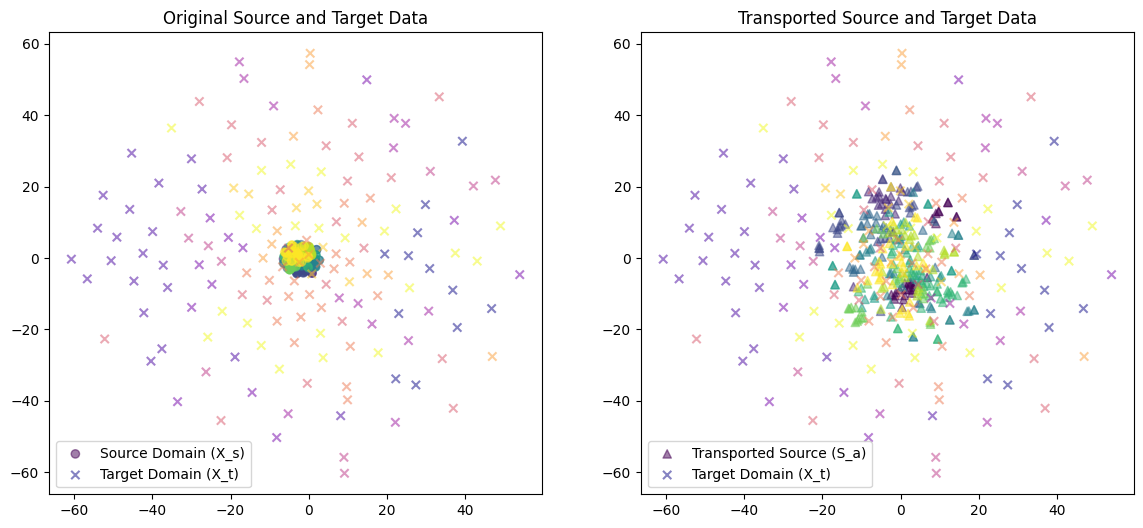

In [49]:
X_s, y_s, X_t, y_t = load_data_surf()

X_s, X_t = preprocess_data(X_s, X_t)

M = compute_cost_matrix(X_s, X_t)

gamma = calculate_coupling_matrix(M, reg_e = 0.01)

print("X_s shape:", X_s.shape)
print("y_s shape:", y_s.shape)
print("X_t shape:", X_t.shape)
print("y_t shape:", y_t.shape)
print("Gamma shape:", gamma.shape)


S_a = transport_source_data(gamma, X_t)
print("S_a shape:", S_a.shape)

accuracy1 = evaluate_transportation(X_s, y_s, X_t, y_t)
print(f"Accuracy before Entropic Regularized Optimal Transport: {accuracy1:.2f}")
accuracy = evaluate_transportation(S_a, y_s, X_t, y_t)
print(f"Accuracy after Entropic Regularized Optimal Transport: {accuracy:.2f}")

visualize_data(X_s, X_t, S_a, y_s, y_t)

In [50]:
reg_e_values = np.linspace(0.1, 5, 20)

best_reg_e = tune_regularization(X_s, y_s, X_t, y_t, reg_e_values)

print()
print(f"Evaluating final model with best reg_e = {best_reg_e}")

gamma = calculate_coupling_matrix(M, best_reg_e)
S_a = transport_source_data(gamma, X_t)
accuracy = evaluate_transportation(S_a, y_s, X_t, y_t)

print()
print(f"Final accuracy with best reg_e: {accuracy:.2f}")

Tuning with reg_e = 0.1...
Accuracy for reg_e=0.1: 0.72611
Tuning with reg_e = 0.35789473684210527...
Accuracy for reg_e=0.35789473684210527: 0.70064
Tuning with reg_e = 0.6157894736842106...
Accuracy for reg_e=0.6157894736842106: 0.69427
Tuning with reg_e = 0.8736842105263158...
Accuracy for reg_e=0.8736842105263158: 0.69427
Tuning with reg_e = 1.1315789473684212...
Accuracy for reg_e=1.1315789473684212: 0.68790
Tuning with reg_e = 1.3894736842105266...
Accuracy for reg_e=1.3894736842105266: 0.68790
Tuning with reg_e = 1.6473684210526318...
Accuracy for reg_e=1.6473684210526318: 0.68790
Tuning with reg_e = 1.905263157894737...
Accuracy for reg_e=1.905263157894737: 0.68790
Tuning with reg_e = 2.1631578947368424...
Accuracy for reg_e=2.1631578947368424: 0.68790
Tuning with reg_e = 2.421052631578948...
Accuracy for reg_e=2.421052631578948: 0.68790
Tuning with reg_e = 2.678947368421053...
Accuracy for reg_e=2.678947368421053: 0.68790
Tuning with reg_e = 2.936842105263158...
Accuracy for r

In [52]:
reg_e_values = np.linspace(0.01, 1, 20) #(0.01, 10, 30)
best_reg_e = tune_regularization_cv(X_s, y_s, X_t, y_t, reg_e_values)

gamma = calculate_coupling_matrix(M, best_reg_e)
S_a = transport_source_data(gamma, X_t)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(S_a, y_s)
y_pred = knn.predict(X_t)
final_accuracy = accuracy_score(y_t, y_pred)

print()
print(f"Final accuracy with best reg_e ({best_reg_e}): {final_accuracy:.4f}")

Tuning with reg_e = 0.01...
Accuracy for reg_e=0.01: 0.3063
Tuning with reg_e = 0.06210526315789474...
Accuracy for reg_e=0.06210526315789474: 0.0063
Tuning with reg_e = 0.11421052631578947...
Accuracy for reg_e=0.11421052631578947: 0.0312
Tuning with reg_e = 0.16631578947368422...
Accuracy for reg_e=0.16631578947368422: 0.0312
Tuning with reg_e = 0.21842105263157896...
Accuracy for reg_e=0.21842105263157896: 0.0312
Tuning with reg_e = 0.2705263157894737...
Accuracy for reg_e=0.2705263157894737: 0.0312
Tuning with reg_e = 0.32263157894736844...
Accuracy for reg_e=0.32263157894736844: 0.0312
Tuning with reg_e = 0.37473684210526315...
Accuracy for reg_e=0.37473684210526315: 0.0312
Tuning with reg_e = 0.4268421052631579...
Accuracy for reg_e=0.4268421052631579: 0.0312
Tuning with reg_e = 0.4789473684210527...
Accuracy for reg_e=0.4789473684210527: 0.0312
Tuning with reg_e = 0.5310526315789474...
Accuracy for reg_e=0.5310526315789474: 0.0312
Tuning with reg_e = 0.5831578947368421...
Accura

## Switching Source and Target Data sets

In [53]:
def load_data_caffenet():
    data_webcam = loadmat('CaffeNet4096/webcam.mat')
    data_dslr = loadmat('CaffeNet4096/dslr.mat')
    X_s = data_dslr['fts']
    y_s = data_dslr['labels'].ravel()
    X_t = data_webcam['fts']
    y_t = data_webcam['labels'].ravel()
    return X_s, y_s, X_t, y_t

def load_data_surf():
    data_webcam = loadmat('surf/webcam.mat')
    data_dslr = loadmat('surf/dslr.mat')
    X_s = data_dslr['fts']
    y_s = data_dslr['labels'].ravel()
    X_t = data_webcam['fts']
    y_t = data_webcam['labels'].ravel()
    return X_s, y_s, X_t, y_t

### With Caffenet

X_s shape: (157, 4096)
y_s shape: (157,)
X_t shape: (295, 4096)
y_t shape: (295,)
Gamma shape: (157, 295)
S_a shape: (157, 4096)
Accuracy before Entropic Regularized Optimal Transport: 0.63
Accuracy after Entropic Regularized Optimal Transport: 0.20


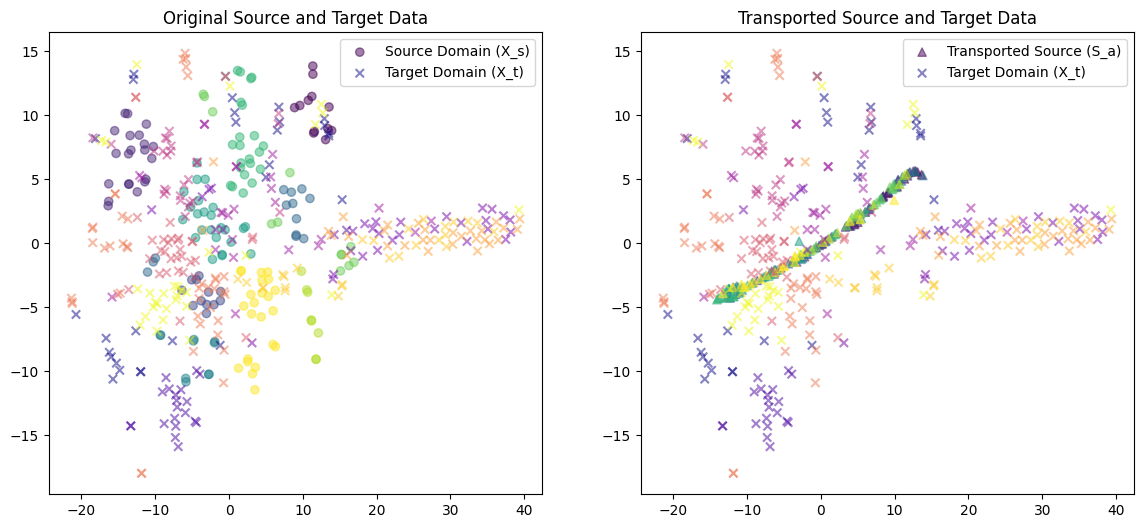

In [54]:
X_s, y_s, X_t, y_t = load_data_caffenet()

X_s, X_t = preprocess_data(X_s, X_t)

M = compute_cost_matrix(X_s, X_t)

gamma = calculate_coupling_matrix(M, reg_e = 5.0)

print("X_s shape:", X_s.shape)
print("y_s shape:", y_s.shape)
print("X_t shape:", X_t.shape)
print("y_t shape:", y_t.shape)
print("Gamma shape:", gamma.shape)


S_a = transport_source_data(gamma, X_t)
print("S_a shape:", S_a.shape)

accuracy1 = evaluate_transportation(X_s, y_s, X_t, y_t)
print(f"Accuracy before Entropic Regularized Optimal Transport: {accuracy1:.2f}")
accuracy = evaluate_transportation(S_a, y_s, X_t, y_t)
print(f"Accuracy after Entropic Regularized Optimal Transport: {accuracy:.2f}")

visualize_data(X_s, X_t, S_a, y_s, y_t)

In [55]:
reg_e_values = np.linspace(0.1, 5, 20)

best_reg_e = tune_regularization(X_s, y_s, X_t, y_t, reg_e_values)

print()
print(f"Evaluating final model with best reg_e = {best_reg_e}")

gamma = calculate_coupling_matrix(M, best_reg_e)
S_a = transport_source_data(gamma, X_t)
accuracy = evaluate_transportation(S_a, y_s, X_t, y_t)

print()
print(f"Final accuracy with best reg_e: {accuracy:.2f}")

Tuning with reg_e = 0.1...
Accuracy for reg_e=0.1: 0.20000
Tuning with reg_e = 0.35789473684210527...
Accuracy for reg_e=0.35789473684210527: 0.20000
Tuning with reg_e = 0.6157894736842106...
Accuracy for reg_e=0.6157894736842106: 0.20000
Tuning with reg_e = 0.8736842105263158...
Accuracy for reg_e=0.8736842105263158: 0.20000
Tuning with reg_e = 1.1315789473684212...
Accuracy for reg_e=1.1315789473684212: 0.20000
Tuning with reg_e = 1.3894736842105266...
Accuracy for reg_e=1.3894736842105266: 0.20000
Tuning with reg_e = 1.6473684210526318...
Accuracy for reg_e=1.6473684210526318: 0.20000
Tuning with reg_e = 1.905263157894737...
Accuracy for reg_e=1.905263157894737: 0.20000
Tuning with reg_e = 2.1631578947368424...
Accuracy for reg_e=2.1631578947368424: 0.20000
Tuning with reg_e = 2.421052631578948...
Accuracy for reg_e=2.421052631578948: 0.20000
Tuning with reg_e = 2.678947368421053...
Accuracy for reg_e=2.678947368421053: 0.20000
Tuning with reg_e = 2.936842105263158...
Accuracy for r

In [56]:
reg_e_values = np.linspace(0.01, 1, 20) #(0.01, 10, 30)
best_reg_e = tune_regularization_cv(X_s, y_s, X_t, y_t, reg_e_values)

gamma = calculate_coupling_matrix(M, best_reg_e)
S_a = transport_source_data(gamma, X_t)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(S_a, y_s)
y_pred = knn.predict(X_t)
final_accuracy = accuracy_score(y_t, y_pred)

print()
print(f"Final accuracy with best reg_e ({best_reg_e}): {final_accuracy:.4f}")

Tuning with reg_e = 0.01...
Accuracy for reg_e=0.01: 0.1593
Tuning with reg_e = 0.06210526315789474...
Accuracy for reg_e=0.06210526315789474: 0.1492
Tuning with reg_e = 0.11421052631578947...
Accuracy for reg_e=0.11421052631578947: 0.1492
Tuning with reg_e = 0.16631578947368422...
Accuracy for reg_e=0.16631578947368422: 0.1492
Tuning with reg_e = 0.21842105263157896...
Accuracy for reg_e=0.21842105263157896: 0.1492
Tuning with reg_e = 0.2705263157894737...
Accuracy for reg_e=0.2705263157894737: 0.1492
Tuning with reg_e = 0.32263157894736844...
Accuracy for reg_e=0.32263157894736844: 0.1492
Tuning with reg_e = 0.37473684210526315...
Accuracy for reg_e=0.37473684210526315: 0.1492
Tuning with reg_e = 0.4268421052631579...
Accuracy for reg_e=0.4268421052631579: 0.1492
Tuning with reg_e = 0.4789473684210527...
Accuracy for reg_e=0.4789473684210527: 0.1492
Tuning with reg_e = 0.5310526315789474...
Accuracy for reg_e=0.5310526315789474: 0.1492
Tuning with reg_e = 0.5831578947368421...
Accura

### With SURF

X_s shape: (157, 800)
y_s shape: (157,)
X_t shape: (295, 800)
y_t shape: (295,)
Gamma shape: (157, 295)
S_a shape: (157, 800)
Accuracy before Entropic Regularized Optimal Transport: 0.33
Accuracy after Entropic Regularized Optimal Transport: 0.80


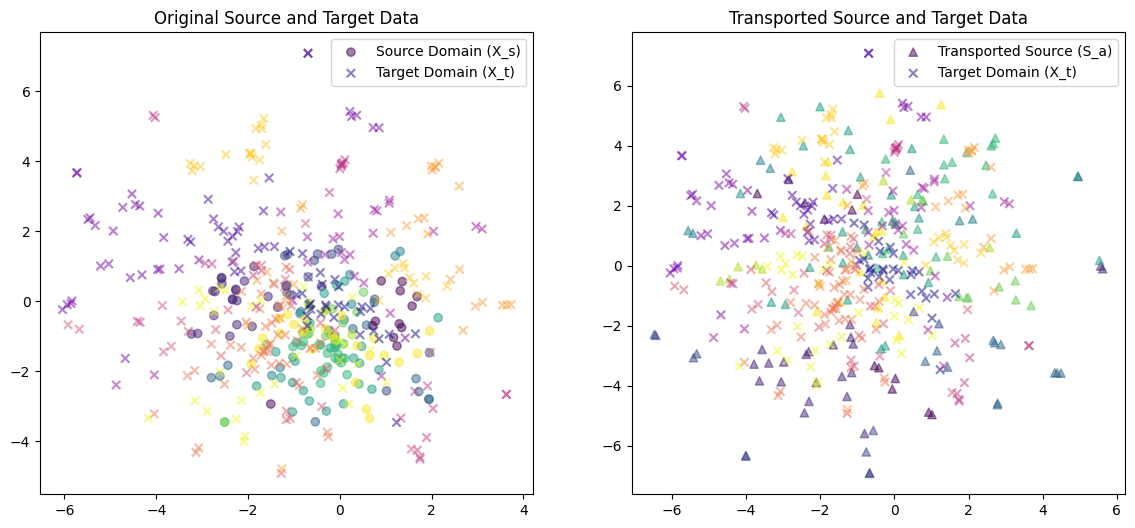

In [57]:
X_s, y_s, X_t, y_t = load_data_surf()

X_s, X_t = preprocess_data(X_s, X_t)

M = compute_cost_matrix(X_s, X_t)

gamma = calculate_coupling_matrix(M, reg_e = 0.01)

print("X_s shape:", X_s.shape)
print("y_s shape:", y_s.shape)
print("X_t shape:", X_t.shape)
print("y_t shape:", y_t.shape)
print("Gamma shape:", gamma.shape)


S_a = transport_source_data(gamma, X_t)
print("S_a shape:", S_a.shape)

accuracy1 = evaluate_transportation(X_s, y_s, X_t, y_t)
print(f"Accuracy before Entropic Regularized Optimal Transport: {accuracy1:.2f}")
accuracy = evaluate_transportation(S_a, y_s, X_t, y_t)
print(f"Accuracy after Entropic Regularized Optimal Transport: {accuracy:.2f}")

visualize_data(X_s, X_t, S_a, y_s, y_t)

In [58]:
reg_e_values = np.linspace(0.1, 5, 20)

best_reg_e = tune_regularization(X_s, y_s, X_t, y_t, reg_e_values)

print()
print(f"Evaluating final model with best reg_e = {best_reg_e}")

gamma = calculate_coupling_matrix(M, best_reg_e)
S_a = transport_source_data(gamma, X_t)
accuracy = evaluate_transportation(S_a, y_s, X_t, y_t)

print()
print(f"Final accuracy with best reg_e: {accuracy:.2f}")

Tuning with reg_e = 0.1...
Accuracy for reg_e=0.1: 0.66441
Tuning with reg_e = 0.35789473684210527...
Accuracy for reg_e=0.35789473684210527: 0.66780
Tuning with reg_e = 0.6157894736842106...
Accuracy for reg_e=0.6157894736842106: 0.66780
Tuning with reg_e = 0.8736842105263158...
Accuracy for reg_e=0.8736842105263158: 0.66780
Tuning with reg_e = 1.1315789473684212...
Accuracy for reg_e=1.1315789473684212: 0.66780
Tuning with reg_e = 1.3894736842105266...
Accuracy for reg_e=1.3894736842105266: 0.66441
Tuning with reg_e = 1.6473684210526318...
Accuracy for reg_e=1.6473684210526318: 0.66441
Tuning with reg_e = 1.905263157894737...
Accuracy for reg_e=1.905263157894737: 0.66441
Tuning with reg_e = 2.1631578947368424...
Accuracy for reg_e=2.1631578947368424: 0.66441
Tuning with reg_e = 2.421052631578948...
Accuracy for reg_e=2.421052631578948: 0.66441
Tuning with reg_e = 2.678947368421053...
Accuracy for reg_e=2.678947368421053: 0.66441
Tuning with reg_e = 2.936842105263158...
Accuracy for r

In [59]:
reg_e_values = np.linspace(0.01, 1, 20) #(0.01, 10, 30)
best_reg_e = tune_regularization_cv(X_s, y_s, X_t, y_t, reg_e_values)

gamma = calculate_coupling_matrix(M, best_reg_e)
S_a = transport_source_data(gamma, X_t)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(S_a, y_s)
y_pred = knn.predict(X_t)
final_accuracy = accuracy_score(y_t, y_pred)

print()
print(f"Final accuracy with best reg_e ({best_reg_e}): {final_accuracy:.4f}")

Tuning with reg_e = 0.01...
Accuracy for reg_e=0.01: 0.1525
Tuning with reg_e = 0.06210526315789474...
Accuracy for reg_e=0.06210526315789474: 0.1525
Tuning with reg_e = 0.11421052631578947...
Accuracy for reg_e=0.11421052631578947: 0.2169
Tuning with reg_e = 0.16631578947368422...
Accuracy for reg_e=0.16631578947368422: 0.2169
Tuning with reg_e = 0.21842105263157896...
Accuracy for reg_e=0.21842105263157896: 0.2136
Tuning with reg_e = 0.2705263157894737...
Accuracy for reg_e=0.2705263157894737: 0.2136
Tuning with reg_e = 0.32263157894736844...
Accuracy for reg_e=0.32263157894736844: 0.2169
Tuning with reg_e = 0.37473684210526315...
Accuracy for reg_e=0.37473684210526315: 0.2169
Tuning with reg_e = 0.4268421052631579...
Accuracy for reg_e=0.4268421052631579: 0.2169
Tuning with reg_e = 0.4789473684210527...
Accuracy for reg_e=0.4789473684210527: 0.2169
Tuning with reg_e = 0.5310526315789474...
Accuracy for reg_e=0.5310526315789474: 0.2271
Tuning with reg_e = 0.5831578947368421...
Accura